In [ ]:
%pip install yfinance matplotlib pytz numpy pandas python-dotenv requests bs4


  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached frozendict-2.4.6-py311-none-any.whl.metadata (23 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.0 MB/s eta 0:00:00 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached bs4-0.0.2-py2.py3-none-any.whl (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 41.6 MB/s eta 0:00:00
Using cached frozendict-2.4.6-py311-none-any.whl (16 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Created wheel for peewee: filename=peewee-3.18.1-cp311-cp311-macosx_15_0_arm64.whl size=285355 sha256=84017a337d80de636430b3e1972fec968dbd7369c9e867a8b0ec54d6a39649a7
  Stored in directory: /Users/andy/Library/Caches/pip/wheels/25/cb/79/a133a0d1d75f318a96614ed7fb97bdf2f35a7b6c4d4e426e3f
Successfully built peewee

[

In [2]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_core.tools import FunctionTool

from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from dotenv import load_dotenv
import os

load_dotenv()

api_version = os.getenv("AZURE_OPENAI_API_VERSION")
api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_chat_completion_client = AzureOpenAIChatCompletionClient(
            model="gpt-4o",
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            api_key=api_key,
)



In [3]:
def google_search(query: str, num_results: int = 2, max_chars: int = 500) -> list:  # type: ignore[type-arg]
    import os
    import time

    import requests
    from bs4 import BeautifulSoup
    from dotenv import load_dotenv

    load_dotenv()

    serp_api_key = os.getenv("SERPAPI_KEY")

    if not serp_api_key:
        raise ValueError("SerpAPI key not found in environment variables")

    url = "https://serpapi.com/search"
    params = {
        "engine": "google",
        "q": query,
        "num": num_results,
        "api_key": serp_api_key,
    }

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(response.json())
        raise Exception(f"Error in API request: {response.status_code}")

    results = response.json().get("organic_results", [])

    def get_page_content(url: str) -> str:
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.content, "html.parser")
            text = soup.get_text(separator=" ", strip=True)
            words = text.split()
            content = ""
            for word in words:
                if len(content) + len(word) + 1 > max_chars:
                    break
                content += " " + word
            return content.strip()
        except Exception as e:
            print(f"Error fetching {url}: {str(e)}")
            return ""

    enriched_results = []
    for item in results:
        body = get_page_content(item["link"])
        enriched_results.append(
            {"title": item["title"], "link": item["link"], "snippet": item.get("snippet", ""), "body": body}
        )
        time.sleep(1)  # Be respectful to the servers

    return enriched_results


In [4]:
def analyze_stock(ticker: str) -> dict:  # type: ignore[type-arg]
    import os
    from datetime import datetime, timedelta

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import yfinance as yf
    from pytz import timezone  # type: ignore

    stock = yf.Ticker(ticker)

    # Get historical data (1 year of data to ensure we have enough for 200-day MA)
    end_date = datetime.now(timezone("UTC"))
    start_date = end_date - timedelta(days=365)
    hist = stock.history(start=start_date, end=end_date)

    # Ensure we have data
    if hist.empty:
        return {"error": "No historical data available for the specified ticker."}

    # Compute basic statistics and additional metrics
    current_price = stock.info.get("currentPrice", hist["Close"].iloc[-1])
    year_high = stock.info.get("fiftyTwoWeekHigh", hist["High"].max())
    year_low = stock.info.get("fiftyTwoWeekLow", hist["Low"].min())

    # Calculate 50-day and 200-day moving averages
    ma_50 = hist["Close"].rolling(window=50).mean().iloc[-1]
    ma_200 = hist["Close"].rolling(window=200).mean().iloc[-1]

    # Calculate YTD price change and percent change
    ytd_start = datetime(end_date.year, 1, 1, tzinfo=timezone("UTC"))
    ytd_data = hist.loc[ytd_start:]  # type: ignore[misc]
    if not ytd_data.empty:
        price_change = ytd_data["Close"].iloc[-1] - ytd_data["Close"].iloc[0]
        percent_change = (price_change / ytd_data["Close"].iloc[0]) * 100
    else:
        price_change = percent_change = np.nan

    # Determine trend
    if pd.notna(ma_50) and pd.notna(ma_200):
        if ma_50 > ma_200:
            trend = "Upward"
        elif ma_50 < ma_200:
            trend = "Downward"
        else:
            trend = "Neutral"
    else:
        trend = "Insufficient data for trend analysis"

    # Calculate volatility (standard deviation of daily returns)
    daily_returns = hist["Close"].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    # Create result dictionary
    result = {
        "ticker": ticker,
        "current_price": current_price,
        "52_week_high": year_high,
        "52_week_low": year_low,
        "50_day_ma": ma_50,
        "200_day_ma": ma_200,
        "ytd_price_change": price_change,
        "ytd_percent_change": percent_change,
        "trend": trend,
        "volatility": volatility,
    }

    # Convert numpy types to Python native types for better JSON serialization
    for key, value in result.items():
        if isinstance(value, np.generic):
            result[key] = value.item()

    # Generate plot
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist["Close"], label="Close Price")
    plt.plot(hist.index, hist["Close"].rolling(window=50).mean(), label="50-day MA")
    plt.plot(hist.index, hist["Close"].rolling(window=200).mean(), label="200-day MA")
    plt.title(f"{ticker} Stock Price (Past Year)")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)

    # Save plot to file
    os.makedirs("coding", exist_ok=True)
    plot_file_path = f"coding/{ticker}_stockprice.png"
    plt.savefig(plot_file_path)
    print(f"Plot saved as {plot_file_path}")
    result["plot_file_path"] = plot_file_path

    return result

In [5]:
google_search_tool = FunctionTool(
    google_search, description="Search Google for information, returns results with a snippet and body content"
)
stock_analysis_tool = FunctionTool(analyze_stock, description="Analyze stock data and generate a plot")

search_agent = AssistantAgent(
    name="Google_Search_Agent",
    model_client=azure_openai_chat_completion_client,
    tools=[google_search_tool],
    description="Search Google for information, returns top 2 results with a snippet and body content",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

stock_analysis_agent = AssistantAgent(
    name="Stock_Analysis_Agent",
    model_client=azure_openai_chat_completion_client,
    tools=[stock_analysis_tool],
    description="Analyze stock data and generate a plot",
    system_message="Perform data analysis.",
)

report_agent = AssistantAgent(
    name="Report_Agent",
    model_client=azure_openai_chat_completion_client,
    description="Generate a report based the search and results of stock analysis",
    system_message="You are a helpful assistant that can generate a comprehensive report on a given topic based on search and stock analysis. When you done with generating the report, reply with TERMINATE.",
)

In [6]:
team = RoundRobinGroupChat([stock_analysis_agent, search_agent, report_agent], max_turns=3)

---------- TextMessage (user) ----------
마이크로소프트 재무 리포트 작성해줘
---------- ToolCallRequestEvent (Stock_Analysis_Agent) ----------
[FunctionCall(id='call_y5ggBrTzM89hmhptAFq57xmy', arguments='{"ticker":"MSFT"}', name='analyze_stock')]


/Users/andy/works/ai/autogen04-sample/.venv/lib/python3.11/site-packages/autogen_agentchat/agents/_assistant_agent.py:981: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  model_result = await model_client.create(


Plot saved as coding/MSFT_stockprice.png
---------- ToolCallExecutionEvent (Stock_Analysis_Agent) ----------
[FunctionExecutionResult(content="{'ticker': 'MSFT', 'current_price': 480.24, '52_week_high': 481.0, '52_week_low': 344.79, '50_day_ma': 432.27633178710937, '200_day_ma': 419.15771591186524, 'ytd_price_change': 63.26312255859375, 'ytd_percent_change': 15.171854235277085, 'trend': 'Upward', 'volatility': 0.2553496584402692, 'plot_file_path': 'coding/MSFT_stockprice.png'}", name='analyze_stock', call_id='call_y5ggBrTzM89hmhptAFq57xmy', is_error=False)]
---------- ToolCallSummaryMessage (Stock_Analysis_Agent) ----------
{'ticker': 'MSFT', 'current_price': 480.24, '52_week_high': 481.0, '52_week_low': 344.79, '50_day_ma': 432.27633178710937, '200_day_ma': 419.15771591186524, 'ytd_price_change': 63.26312255859375, 'ytd_percent_change': 15.171854235277085, 'trend': 'Upward', 'volatility': 0.2553496584402692, 'plot_file_path': 'coding/MSFT_stockprice.png'}
---------- ToolCallRequestEve

/Users/andy/works/ai/autogen04-sample/.venv/lib/python3.11/site-packages/autogen_agentchat/agents/_assistant_agent.py:981: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  model_result = await model_client.create(


---------- ToolCallExecutionEvent (Google_Search_Agent) ----------
[FunctionExecutionResult(content="[{'title': 'FY23 Q3 - Press Releases - Investor Relations', 'link': 'https://www.microsoft.com/en-us/investor/earnings/fy-2023-q3/press-release-webcast', 'snippet': 'Earnings Release FY23 Q3 · Revenue was $52.9 billion and increased 7% (up 10% in constant currency) · Operating income was $22.4 billion and increased 10% (up 15% ...', 'body': 'Your request has been blocked. This could be due to several reasons. Skip to main content Microsoft Microsoft 365 Teams Copilot Windows Surface Xbox Deals Small Business Support More All Microsoft Office Windows Surface Xbox Deals Support Software Windows Apps OneDrive Outlook Skype OneNote Microsoft Teams Microsoft Edge PCs & Devices Computers Shop Xbox Accessories VR & mixed reality Phones Entertainment Xbox Game Pass Ultimate Xbox Live Gold Xbox games PC games Windows digital games Movies &'}, {'title': 'FY23 Q3 - Income Statement - Investor Rela

TaskResult(messages=[TextMessage(source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 6, 20, 7, 24, 0, 89817, tzinfo=datetime.timezone.utc), content='마이크로소프트 재무 리포트 작성해줘', type='TextMessage'), ToolCallRequestEvent(source='Stock_Analysis_Agent', models_usage=RequestUsage(prompt_tokens=70, completion_tokens=17), metadata={}, created_at=datetime.datetime(2025, 6, 20, 7, 24, 1, 123455, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_y5ggBrTzM89hmhptAFq57xmy', arguments='{"ticker":"MSFT"}', name='analyze_stock')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='Stock_Analysis_Agent', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 6, 20, 7, 24, 7, 900425, tzinfo=datetime.timezone.utc), content=[FunctionExecutionResult(content="{'ticker': 'MSFT', 'current_price': 480.24, '52_week_high': 481.0, '52_week_low': 344.79, '50_day_ma': 432.27633178710937, '200_day_ma': 419.15771591186524, 'ytd_price_change': 63.2631225585937

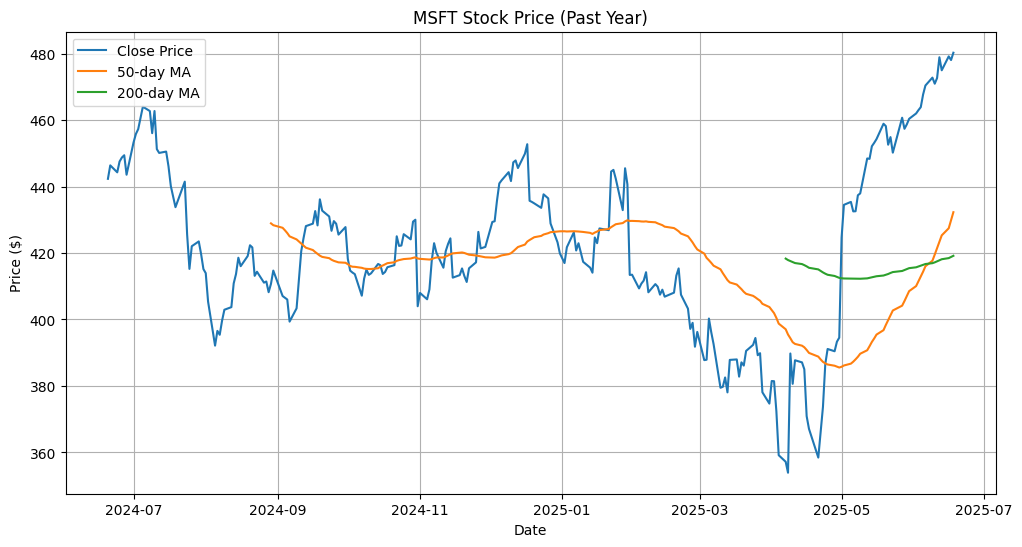

In [7]:
stream = team.run_stream(task="마이크로소프트 재무 리포트 작성해줘")
await Console(stream)